# Linear Dynamical System

In [3]:
import matplotlib.pyplot as plt

import numpy as np
import jax.numpy as jnp

from extravaganza.dynamical_systems import LDS

from extravaganza.controllers import LiftedBPC
from extravaganza.lifters import NoLift, RandomLift, LearnedLift
from extravaganza.sysid import SysID
from extravaganza.controllers import LQR, BPC, GPC, RBPC
from extravaganza.rescalers import ADAM, D_ADAM, DoWG
from experiments import run_experiment, ylim

# seeds for randomness. setting to `None` uses random seeds
SYSTEM_SEED = 6
CONTROLLER_SEED = None
LIFTER_AND_SYSID_SEED = None

## System
Here, we work with a Linear Dynamical System (LDS) with various types of perturbations.

The states $\{x_t\}_{t}$ evolve with
$$x_{t+1} = A x_{t} + B u_t + w_t,$$
where $A$ and $B$ are randomly generated dynamics, $u_t$ is the input control, and $w_t$ is the output of one of the below disturbance schedules.

The costs are denoted by $f(x_t, u_t)$ and given by the below cost functions.

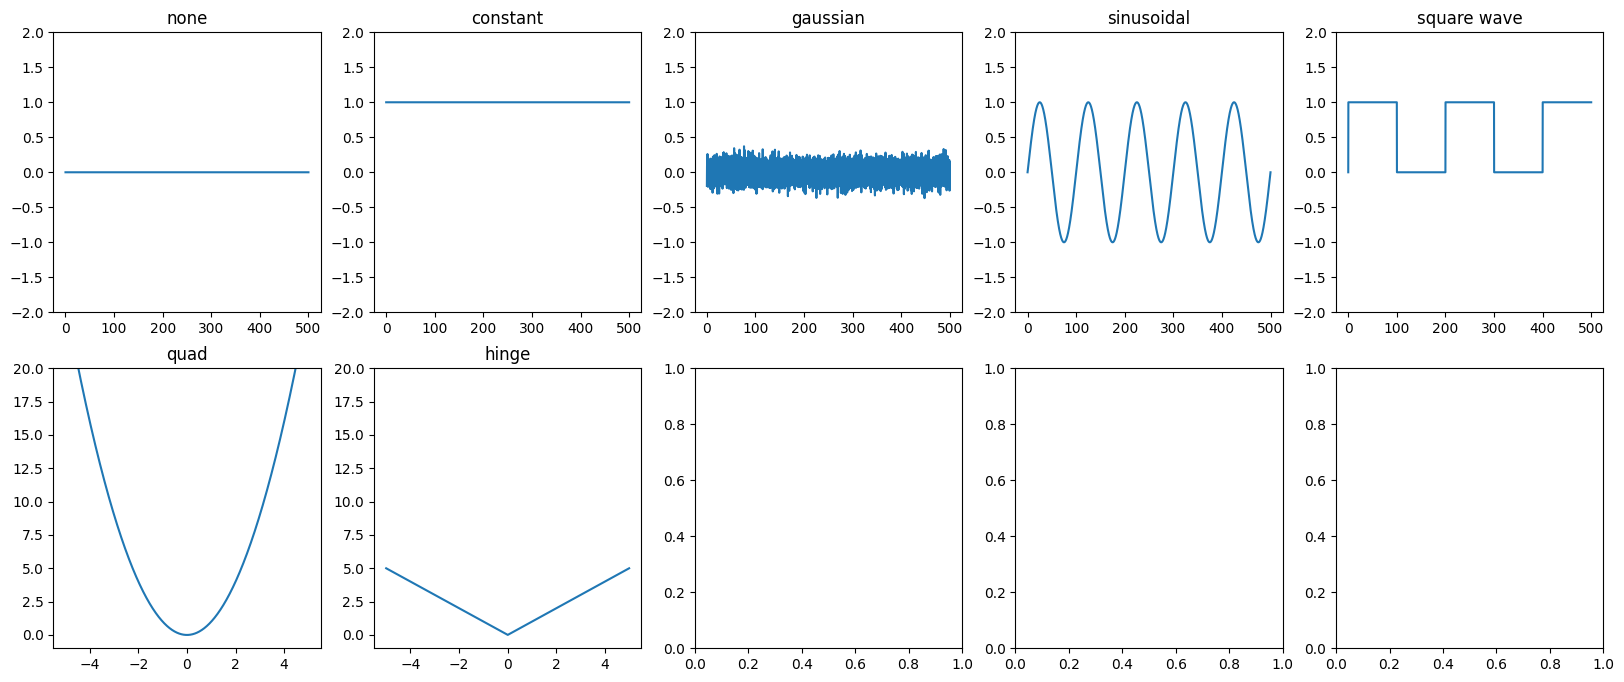

In [4]:
disturbance_fns = {'none': lambda t: 0.,
                   'constant': lambda t: 1.,
                   'gaussian': lambda t: np.random.randn() * 0.1,  # variance of 0.01
#                    'linear': lambda t: float(t),  # this one is stupid
                   'sinusoidal': lambda t: np.sin(2 * np.pi * t / 100),  # period of 100 steps
                   'square wave': lambda t: np.ceil(t / 100) % 2  # period of 40
                  }

cost_fns = {'quad': lambda x, u: jnp.dot(x, x) + jnp.dot(u, u),
            'hinge': lambda x, u: jnp.sum(jnp.abs(x)) + jnp.sum(jnp.abs(u))}

num_points = 10000
fig, ax = plt.subplots(2, len(disturbance_fns), figsize=(4 * len(disturbance_fns), 8))
for i, (k, fn) in enumerate(disturbance_fns.items()):
    xs = np.linspace(0, 500, num_points)
    ax[0, i].plot(xs, [fn(t) for t in xs])
    ax[0, i].set_ylim(-2, 2)
    ax[0, i].set_title(k)
for i, (k, fn) in enumerate(cost_fns.items()):
    xs = np.linspace(-5, 5, num_points)
    ax[1, i].plot(xs, [fn(t, 0) for t in xs])
    ax[1, i].set_ylim(-1, 20)
    ax[1, i].set_title(k)    
plt.show()

## Hyperparameters

In [5]:
# --------------------------------------------------------------------------------------
# ------------------------    EXPERIMENT HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

num_trials = 1
T = 5000  # total timesteps
T0 = 2600  # number of timesteps to just sysid for our methods
reset_every = None  # how often to reset the system
wordy = True  # whether to print some things

# --------------------------------------------------------------------------------------
# --------------------------    SYSTEM HYPERPARAMETERS    ------------------------------
# --------------------------------------------------------------------------------------

du = 1  # control dim
ds = 1  # state dim

disturbance_type = 'sinusoidal'
cost_fn = 'quad'

make_system = lambda : LDS(ds, du, disturbance_type, cost_fn, seed=SYSTEM_SEED)

# --------------------------------------------------------------------------------------
# ------------------------    LIFT/SYSID HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

sysid_method = 'regression'
sysid_scale = 0.3

learned_lift_args = {
    'lift_lr': 0.001,
    'sysid_lr': 0.001,
    'cost_lr': 0.001,
    'depth': 4,
    'buffer_maxlen': int(1e6),
    'num_epochs': 50,
    'batch_size': 64,
    'seed': LIFTER_AND_SYSID_SEED
}

# --------------------------------------------------------------------------------------
# ------------------------    CONTROLLER HYPERPARAMETERS    ----------------------------
# --------------------------------------------------------------------------------------

h = 10  # controller memory length (# of w's to use on inference)
hh = 10  # history length of the cost/control histories
lift_dim = 20  # dimension to lift to

m_update_rescaler = lambda : ADAM(0.002, betas=(0.9, 0.999))
m0_update_rescaler = lambda : ADAM(0.002, betas=(0.9, 0.999))
k_update_rescaler = lambda : ADAM(0.00, betas=(0.99, 0.999))

lifted_bpc_args = {
    'h': h,
    'method': 'REINFORCE',
    'initial_scales': (0.01, 0.01, 0.0),  # M, M0, K   (uses M0's scale for REINFORCE)
    'rescalers': (m_update_rescaler, m0_update_rescaler, k_update_rescaler),
    'T0': T0,
    'bounds': None,
    'initial_u': jnp.zeros(du),
    'decay_scales': False,
    'use_sigmoid': False,
    'use_K_from_sysid': True,
    'seed': CONTROLLER_SEED
}

make_controllers = {
    'LQR': lambda sys: LQR(sys.A, sys.B, jnp.eye(ds), sys.R, seed=CONTROLLER_SEED),
    'GPC': lambda sys: GPC(sys.A, sys.B, Q=jnp.eye(ds), R=sys.R, H=h, lr_scale=0.01, decay=True, seed=CONTROLLER_SEED),
    'BPC': lambda sys: BPC(sys.A, sys.B, Q=jnp.eye(ds), R=sys.R, H=h, lr_scale=0.01, delta=0.01, seed=CONTROLLER_SEED),
    'RBPC': lambda sys: RBPC(sys.A, sys.B, Q=jnp.eye(ds), R=sys.R, H=h, M=h, lr=0.01, delta=0.01, noise_sd=0.05, seed=CONTROLLER_SEED),
    
    'No Lift': lambda sys: LiftedBPC(lifter=NoLift(hh, du, LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, hh, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
    'Random Lift': lambda sys: LiftedBPC(lifter=RandomLift(hh, du, lift_dim, learned_lift_args['depth'], LIFTER_AND_SYSID_SEED), sysid=SysID(sysid_method, du, lift_dim, sysid_scale, LIFTER_AND_SYSID_SEED), **lifted_bpc_args),
    'Learned Lift': lambda sys: LiftedBPC(lifter=LearnedLift(hh, du, lift_dim, scale=sysid_scale, **learned_lift_args), **lifted_bpc_args)
}

## Plotting
We keep track of the useful information through `Stats` objects, which can `register()` a variable to keep track of (which it does via calls to `update()`) and which can be aggregated via `Stats.aggregate()` for mean and variance statistics. 

We define below a plotting arrangement that plots all the desired quantities from both the system and controller.

In [6]:
def plot_lds(all_stats):
    # clear plot and calc nrows
    plt.clf()
    n = 4
    nrows = n + (len(all_stats) + 1) // 2
    fig, ax = plt.subplots(nrows, 2, figsize=(16, 4 * nrows))

    # plot stats
    for i, (method, stats) in enumerate(all_stats.items()):
        if stats is None: 
            print('WARNING: {} had no stats'.format(method))
            continue
        stats.plot(ax[0, 0], 'xs', label=method)
#         stats.plot(ax[0, 1], 'ws', label=method)
        stats.plot(ax[3, 1], 'us', label=method)
        if 'costs' in stats:
            stats.plot(ax[1, 0], 'avg costs', label=method)
            stats.plot(ax[1, 1], 'costs', label=method)
        else:
            stats.plot(ax[1, 0], 'avg fs', label=method)
            stats.plot(ax[1, 1], 'fs', label=method)
    
        stats.plot(ax[2, 0], '||A||_op', label=method)
        stats.plot(ax[2, 1], '||B||_F', label=method)
        stats.plot(ax[3, 0], '||A-BK||_op', label=method)
        i_ax = ax[n + i // 2, i % 2]
        stats.plot(ax[0, 1], 'disturbances', label=method)
        stats.plot(i_ax, 'K @ state', label='K @ state')
        stats.plot(i_ax, 'M \cdot w', label='M \cdot w')
        stats.plot(i_ax, 'M0', label='M0')
        i_ax.set_title('u decomp for {}'.format(method))
        i_ax.legend()

    # set titles and legends and limits and such
    # (note: `ylim()` is so useful! because sometimes one thing blows up and then autoscale messes up all plots)
    _ax = ax[0, 0]; _ax.set_title('position'); _ax.legend(); ylim(_ax, -5, 20)
    _ax = ax[0, 1]; _ax.set_title('disturbances'); _ax.legend(); ylim(_ax, -0.1, 0.1)
    _ax = ax[1, 0]; _ax.set_title('avg costs'); _ax.legend(); ylim(_ax, -5, 100)
    _ax = ax[1, 1]; _ax.set_title('costs'); _ax.legend(); ylim(_ax, -5, 100)
    
    _ax = ax[2, 0]; _ax.set_title('||A||_op'); _ax.legend()
    _ax = ax[2, 1]; _ax.set_title('||B||_F'); _ax.legend()
    
    _ax = ax[3, 0]; _ax.set_title('||A-BK||_op'); _ax.legend()
    _ax = ax[3, 1]; _ax.set_title('controls'); _ax.legend(); ylim(_ax, -3, 3)
    pass

## actually run the thing :)

--------------------------------------------------
----------------- TRIAL 0 -----------------------
--------------------------------------------------

testing LQR
registering running average of fs


 57%|█████████████████████████████████▋                         | 2860/5000 [00:02<00:01, 1306.78it/s, state=-.215, control=-.121, cost=0.0619]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1363.49it/s, state=-.0067, control=-.00378, cost=0.000125]



testing GPC
registering running average of fs


100%|█████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 347.95it/s, state=0.0222, control=0.0479, cost=0.00308]



testing BPC
registering running average of fs


 79%|███████████████████████████████████████▌          | 3955/5000 [00:14<00:03, 276.10it/s, state=-1.29e+16, control=-2.42e+31, cost=3.31e+32]



testing RBPC
registering running average of fs


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:52<00:00, 94.46it/s, state=-.0448, control=-.0446, cost=0.00222]



testing No Lift
registering running average of fs
registering running average of costs


 52%|███████████████████████████████▏                            | 2595/5000 [00:08<00:08, 300.27it/s, state=0.537, control=0.0886, cost=0.337]

copying the K from <extravaganza.sysid.SysID object at 0x2b3dd67a0>
solving DARE with unconstrained Q
||A||_op = 0.9746595025062561     ||B||_F 0.03405851125717163         ||A-BK||_op = 0.9512694478034973


 52%|████████████████████████████▋                          | 2606/5000 [00:09<00:08, 271.35it/s, state=1.41e+10, control=1.26e+20, cost=4e+20]



testing Random Lift
registering running average of fs
registering running average of costs


 52%|████████████████████████████████▌                              | 2583/5000 [00:11<00:10, 232.40it/s, state=1.05, control=-.116, cost=1.16]

copying the K from <extravaganza.sysid.SysID object at 0x2b31bbaf0>
solving DARE with unconstrained Q


100%|████████████████████████████████████████████████████████| 5000/5000 [00:45<00:00, 109.39it/s, state=0.00931, control=0.0227, cost=0.00117]



testing Learned Lift
registering running average of fs
registering running average of costs


 51%|███████████████████████████████▉                              | 2574/5000 [00:08<00:08, 284.21it/s, state=0.698, control=0.25, cost=0.508]

copying the K from <extravaganza.lifters.LearnedLift object at 0x2be659720>
training!
mean loss for past 25 epochs was 0.010832413751631974
mean loss for past 25 epochs was 0.0005642927926965058


 52%|███████████████████████████████▊                             | 2603/5000 [00:13<01:48, 22.10it/s, state=0.502, control=-.0088, cost=0.252]

solving DARE with unconstrained Q
||A||_op = 0.9629601240158081     ||B||_F 0.6300951242446899         ||A-BK||_op = 0.9629541039466858


100%|█████████████████████████████████████████████████████████████| 5000/5000 [00:45<00:00, 109.35it/s, state=0.371, control=0.716, cost=0.675]
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


<Figure size 640x480 with 0 Axes>

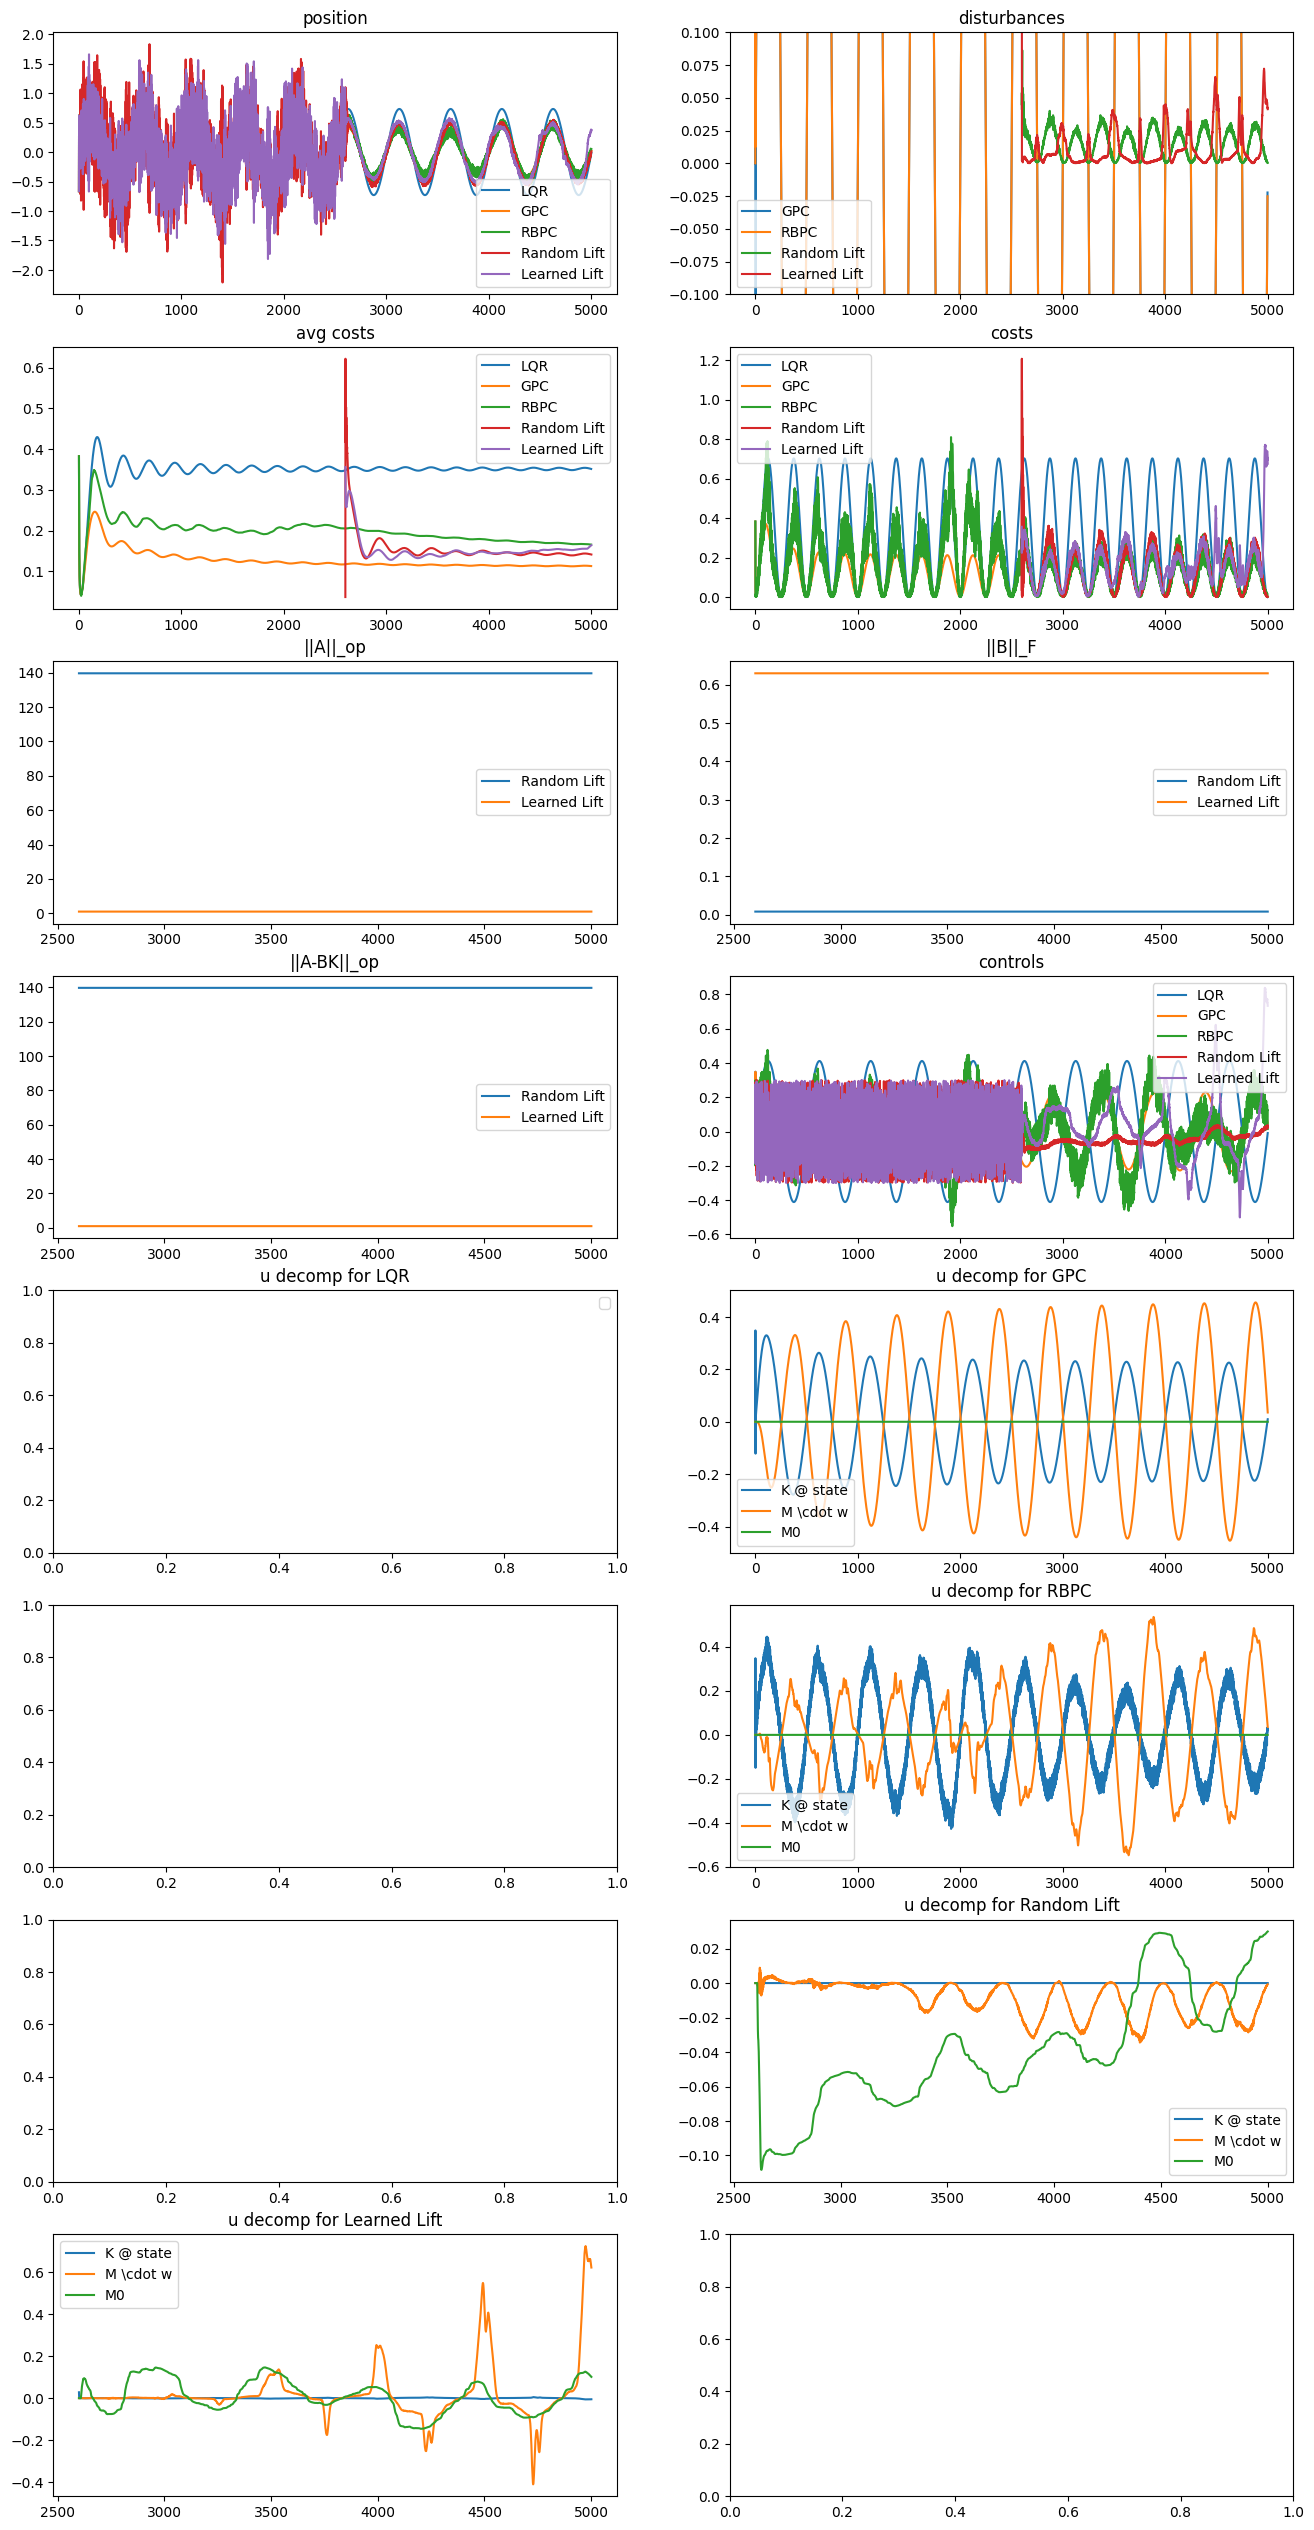

In [7]:
experiment_args = {
    'make_system': make_system,
    'make_controllers': make_controllers,
    'num_trials': num_trials,
    'T': T,
    'reset_every': reset_every,
    'reset_seed': SYSTEM_SEED,
    'wordy': wordy,
    
}
stats = run_experiment(**experiment_args)
plot_lds(stats)

In [8]:
# save stats!

# import dill
# name = 'lds_constant'

# with open('../logs/{}.pkl'.format(name), 'wb') as f:
#     val = (experiment_args, stats)
#     dill.dump(val, f)